In [1]:
import torch
from config import *
import pickle
device = torch.device('cpu')
import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
learning_rate = 0.002
dropout = 0.1
uni_param =  0.08
batch_size = 128
model_type = 'gru'
hidden_size = 64
evals = 100

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = (4, 3)

In [3]:
dcon = DataConfig('data', input_seq_length = 100, target_seq_length = 1, train_frac = 0.8, val_frac = 0.1, test_frac = 0.1, batch_size = 128, blank = True)    

In [9]:
sch = torch.optim.lr_scheduler.MultiStepLR
sch_params = {'milestones': range(10, 50), 'gamma': 0.95}
max_epoch = 15
le_epoch = 6

In [10]:
mcon = ModelConfig(model_type, 1, hidden_size, dcon.input_size, dropout, 'uni', {'a': -uni_param, 'b':uni_param}, device, bias = False, id_init_param = 'b')
tcon = TrainConfig('Models', batch_size, max_epoch, 'adam', learning_rate, {}, scheduler = sch, scheduler_params= sch_params, start_epoch = 0)
fcon = FullConfig(dcon, tcon, mcon)

In [11]:
# le = torch.load('LE_stats/{}_{}_LEs.p'.format(model_type, hidden_size))
for i, hidden_size in enumerate([64, 128, 256]):
    le = torch.load('LE_stats/{}_{}_e{}_LEs.p'.format(model_type, hidden_size, le_epoch))
    for factor in [2, 4, 8, 0][:-i-1]:
        print('Hidden_size: {}, Factor: {}'.format(hidden_size, factor))
        shift = torch.cat((le[:, 1:], torch.zeros((evals, 1), device = device, dtype = le.dtype)), dim = 1)
        diffs = (le - shift)/2; diffs[:, -1] = diffs[:, -2]
        test = torch.zeros(evals, 0)
        for col, diff in zip(le.T, diffs.T):
            test = torch.cat((test, col.unsqueeze(1)), dim = 1)
            test = torch.cat((test, (col-diff).unsqueeze(1)), dim = 1)
            le = test
#         print(le[:, -1])
        torch.save(le, 'LE_stats/{}_{}_e{}_LEs_aug_{}.p'.format(model_type, hidden_size, le_epoch, factor))

Hidden_size: 64, Factor: 2
Hidden_size: 64, Factor: 4
Hidden_size: 64, Factor: 8
Hidden_size: 128, Factor: 2
Hidden_size: 128, Factor: 4
Hidden_size: 256, Factor: 2


In [14]:
le_data = torch.zeros((0, 512))
for i, hidden_size in enumerate([64, 128, 256]):
    factor = [2, 4, 8][-i-1]
    le_data = torch.cat((le_data, torch.load('LE_stats/{}_{}_e{}_LEs_aug_{}.p'.format(model_type, hidden_size, le_epoch, factor))))
hidden_size = 512
le_data = torch.cat((le_data, torch.load('LE_stats/{}_{}_e{}_LEs.p'.format(model_type, hidden_size, le_epoch))))
print(le_data.shape)

torch.Size([400, 512])


In [19]:
vl_targets = torch.zeros((0))
tl_targets = torch.zeros((0))
for i, hidden_size in enumerate([64, 128, 256, 512]):
    vl_targets = torch.cat((vl_targets, torch.load('LE_stats/{}_{}_valLoss.p'.format(model_type, hidden_size, factor))))
    tl_targets = torch.cat((tl_targets, torch.load('LE_stats/{}_{}_trainLoss.p'.format(model_type, hidden_size, factor))))

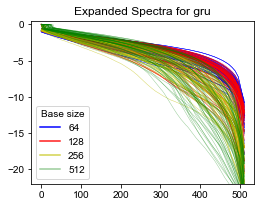

In [20]:
f = plt.figure(figsize = (4, 3))
plt.title('Expanded Spectra for {}'.format(model_type))
plt.plot(range(512), le_data[60*0:60*(0+1)].T, 'b', alpha = 1., linewidth = .5);
plt.plot(range(512), le_data[60*0].T, 'b', alpha = 1., label = 64);
plt.plot(range(512), le_data[60*1:60*(1+1)].T, 'r', alpha = .8, linewidth = 0.5);
plt.plot(range(512), le_data[60*1].T, 'r', alpha = .9, label = 128);
plt.plot(range(512), le_data[60*2:60*(2+1)].T, 'y', alpha = .6, linewidth = 0.5);
plt.plot(range(512), le_data[60*2].T, 'y', alpha = .7, label = 256);
plt.plot(range(512), le_data[60*3:60*(3+1)].T, 'g', alpha = .4, linewidth = 0.5);
plt.plot(range(512), le_data[60*3].T, 'g', alpha = .4, label = 512);
plt.legend(title = 'Base size')
plt.ylim([-22, 0.5])
plt.savefig('Figures/{}_AllSpectra.png'.format(model_type), bbox_inches="tight",dpi=400, format = 'png')

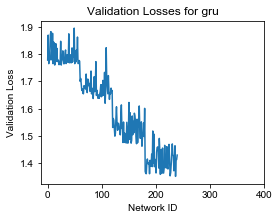

In [21]:
plt.figure(figsize = (4,3))
plt.plot(vl_targets)
plt.xticks([0, evals, 2*evals, 3*evals, 4*evals])
plt.ylabel('Validation Loss')
plt.xlabel('Network ID')
plt.title('Validation Losses for {}'.format(model_type))
plt.savefig('Figures/{}_AllLosses.png'.format(model_type), bbox_inches="tight",dpi=400, format = 'png')

In [48]:
torch.save(vl_targets, 'Correlation/{}_fullValLoss.p'.format(model_type))

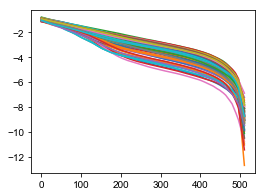

In [15]:
hidden_size = 64
plt.plot(range(512), torch.load('LE_stats/{}_{}_LEs_aug_{}.p'.format(model_type, hidden_size, int(512/hidden_size))).T);

In [16]:
from sklearn.model_selection import train_test_split

In [35]:
fcon.model.model_type = 'gru'

In [43]:
p_list = []
vl_targets = []
tl_targets = []
for hidden_size in [64, 128, 256, 512]:
    fcon.model.rnn_atts['hidden_size'] = hidden_size
    trials = pkl.load(open('{}_trials_{}.p'.format(fcon.model.model_type, hidden_size), 'rb'))
    for trial in trials:
        vl_targets.append(trial['result']['val_loss'])
        tl_targets.append(trial['result']['loss'])
        p_list.append(trial['misc']['vals']['param'][0])
p_list = torch.Tensor(p_list)
vl_targets = torch.Tensor(vl_targets)
tl_targets = torch.Tensor(tl_targets)


In [28]:
idcs = range(0, p_list.shape[0])

In [44]:
le_train, le_val, tl_train, tl_val, vl_train, vl_val, param_train, param_val, idx_train, idx_val = train_test_split(le_data.numpy(), tl_targets.numpy(), vl_targets.numpy(), p_list.numpy(), np.array(idcs), train_size = 0.8)

In [45]:
le_train = torch.Tensor(le_train)
le_val = torch.Tensor(le_val)
tl_train = torch.Tensor(tl_train)
tl_val = torch.Tensor(tl_val)
vl_train = torch.Tensor(vl_train)
vl_val = torch.Tensor(vl_val)
param_train = torch.Tensor(param_train)
param_val = torch.Tensor(param_val)
idx_train = torch.Tensor(idx_train)
idx_val = torch.Tensor(idx_val)

In [46]:
torch.save([le_train, tl_train, vl_train, param_train, idx_train], 'Correlation/{}_train.p'.format(model_type))
torch.save([le_val, tl_val, vl_val, param_val, idx_val], 'Correlation/{}_val.p'.format(model_type))

In [232]:
a = []
idcs = []
for idx in range(4):
    mins = torch.min(vl_targets[60*idx:60*(idx+1)], dim = 0)
    maxs = torch.max(vl_targets[60*idx:60*(idx+1)], dim = 0)
    a.append([mins[0], maxs[0]])
    idcs.append([mins[1], maxs[1]])

In [233]:
a

[[tensor(1.8569), tensor(2.0125)],
 [tensor(1.7081), tensor(1.8558)],
 [tensor(1.5302), tensor(1.6556)],
 [tensor(1.3944), tensor(1.4966)]]

In [234]:
idcs

[[tensor(48), tensor(42)],
 [tensor(49), tensor(4)],
 [tensor(45), tensor(8)],
 [tensor(57), tensor(28)]]

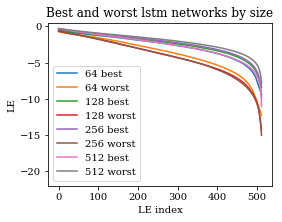

In [235]:
plt.figure(figsize = (4,3))
sizes = [64,128,256,512]
for idx in range(4):
    plt.plot(range(512), le_data[60*idx+idcs[idx][0], :].T, label = '{} best'.format(sizes[idx]))
    plt.plot(range(512), le_data[60*idx+idcs[idx][1], :].T, label = '{} worst'.format(sizes[idx]))
#     a.append([mins[0], maxs[0]])
#     idcs.append([mins[1], maxs[1]])
plt.legend()
plt.ylabel('LE')
plt.xlabel('LE index')
plt.title('Best and worst {} networks by size'.format(model_type))
plt.legend()
plt.ylim([-22, 0.5])
plt.savefig('Figures/{}_Best_Worst.png'.format(model_type), bbox_inches="tight",dpi=400, format = 'png')

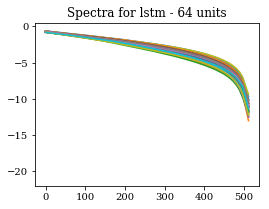

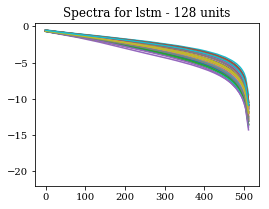

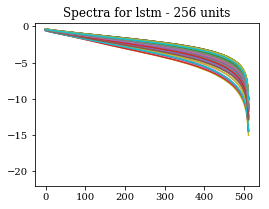

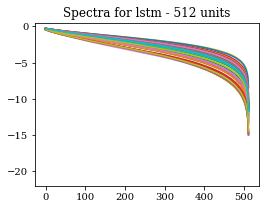

In [236]:
sizes = [64,128,256,512]
for idx in range(4):
    plt.figure(figsize = (4,3))
    plt.plot(range(512), le_data[60*idx:60*(idx+1),:].T)
    plt.title('Spectra for {} - {} units'.format(model_type, sizes[idx]))
    plt.ylim([-22,0.5])
    plt.savefig('Figures/{}_{}_spectra.png'.format(model_type, sizes[idx]), bbox_inches="tight",dpi=400, format = 'png')

In [47]:
torch.save(le_data, f'Correlation/{model_type}_allLEs.p')
torch.save(p_list, f'Correlation/{model_type}_allParams.p')